# Lab 3 CNN Visualization

Team members: Alex Shockley, Rick Lattin, Will Landin

In [1]:
from tensorflow.keras.applications.vgg19 import preprocess_input,decode_predictions
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import models

#VGG 19
vgg = tf.keras.applications.VGG19()
#https://www.kaggle.com/datasets/deeptrial/miniimagenet <- Dataset that contains a few of each class in image net (used so we dont have to download the whole like 0.5Tb thing)


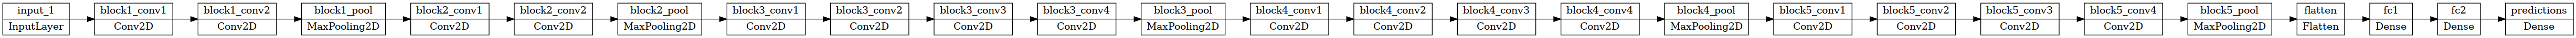

In [2]:
tf.keras.utils.plot_model(vgg,rankdir='LR')

# Model Selection

We chose to use VGG19 as our pre-trained convolutional neural network to visualize. We chose VGG19 for several reasons. Firstly, unlike resnet, there are no residual connections in it which makes visualizing circuits easier because there is a single layer feeding forward to the next layer. This removes the complexity of visualizing not only the prior layer but also layers much further away to show how a circuit connection is made. Secondly, the architecture is readily accessible through TensorFlow's application module which makes getting the layers much easier because it is built into the TensorFlow package and not a download. Lastly, VGG19, or at least the version that we are using, was trained on Image Net which has a wide variety of different classes. We hypothesize that with this wide variety of classes, we will see more interesting filters because some filters will be useful for classifying certain classes such as animals, while other filters will be almost only for classifying other objects such as trucks or cars. We were curious about whether or not there would be any overlap between these categories of classes, meaning that is there a filter that is looking for characteristics that can appear in both animals and cars (without being polysemantic).

VGG19 consists of several blocks of convolution followed by maxpools before finally being flattened and passed to a fully connected layer for classification. The convolutions in VGG19 are all 3x3 but the blocks have varying numbers of filters. The number of filters per block is as follows:
 - Block 1: 2 layers each containing 64 3x3 filters
 - Block 2: 2 layers each containing 128 3x3 filters
 - Block 3: 4 layers each containing 256 3x3 filters
 - Block 4: 4 layers each containing 512 3x3 filters
 - Block 5: 4 layers each containing 512 3x3 filters

# Image Processing

In [3]:
IMG_SHAPE = (224,224)

In [4]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')

In [5]:
def clean_image_directory(filepath): #Will remove greyscale images from directory (and the single mf image that has 4 channels for some god forsaken reason)
    data = {}
    for subfolder in os.listdir(filepath):
        data[subfolder] = 0
        subfolder_path = os.path.join(filepath,subfolder)
        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path,img_name)
            img = Image.open(img_path)
            if img.mode == "L" or np.array(img).shape[-1] > 3:
                print(f'Removed {img_path}')
                os.remove(img_path)
            else:
                data[subfolder] = data[subfolder] + 1
    # print(data)
    # print(min(data.values()))

clean_image_directory('./ImageNet-Mini/images')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


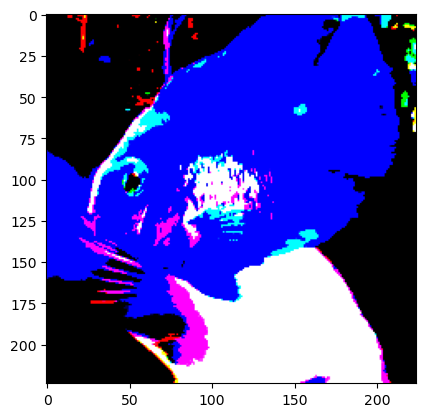

In [6]:
def load_image_for_processing(filepath,prep_for_vgg=True):
    img = Image.open(filepath)
    img = img.resize(size=IMG_SHAPE) #reisze to model's input expectation (can change model input and this still works)
    img = np.array(img)
    if prep_for_vgg:
        img = preprocess_input(img)
    return img



plt.imshow(load_image_for_processing('ImageNet-Mini/images/n01443537/ILSVRC2012_val_00000994.JPEG',prep_for_vgg=True))

In [7]:
import json
import pprint
pp = pprint.PrettyPrinter(indent=3)
def get_name_mapper(filepath):
    with open(filepath,'r') as fp:
        dct = json.load(fp)
        # pp.pprint(dct)
        _dct = {}
        for val in dct.values():
            _dct[val[0]] = val[1]
    return _dct
            

In [9]:
def get_example_images(directory_path,num_classes=2,num_examples_per_class=2,prep_for_vgg=False,name_mapper_filepath='ImageNet-Mini/imagenet_class_index.json'):
    """
    This function is designed to accept a directory path that contains directories of images and will parse them into a data dictionary keyed by class and the value will be an array of the images within that folder
    Num_classes (Int): Number of classes to select from the directories. Chosen randomly. If num_classes > max# of classes, will select all classes in the directory
    num_examples_per_class (Int): Max number of images to select per class. Will choose all images if there are less than the num_examples_per_class
    prep_for_vgg (Bool): Whether or not to run the preprocess_input() function from vgg on the image before returning it
    name_mapper_filepath (String): Filepath to the json file that tells us what the classes are (meaning map n01440764 -> "dog") so it is readable by humans
    """
    possible_classes = os.listdir(directory_path)
    num_classes = min(len(possible_classes),num_classes)
    chosen_classes = np.random.choice(possible_classes,size=num_classes,replace=False)
    print(f'Classes Chosen: {chosen_classes}')
    data = {}
    mapper = get_name_mapper(name_mapper_filepath)

    for cls in chosen_classes:
        mapped_class = mapper.get(cls,None)
        if mapped_class is None:
            raise RuntimeError(f'Could not look up class {cls}')
        data[mapped_class] = []
        cls_pth = os.path.join(directory_path,cls)
        images = os.listdir(cls_pth)
        # print(len(images))
        images = np.random.choice(images,size=min(num_examples_per_class,len(images)),replace=False)
        for img in images:
            img_pth = os.path.join(cls_pth,img)
            the_img = load_image_for_processing(img_pth,prep_for_vgg=prep_for_vgg)

            data[mapped_class].append(the_img)
            # print(data[-1].shape)
    # print(data)
    return data


result = get_example_images('ImageNet-Mini/images',num_classes=10)


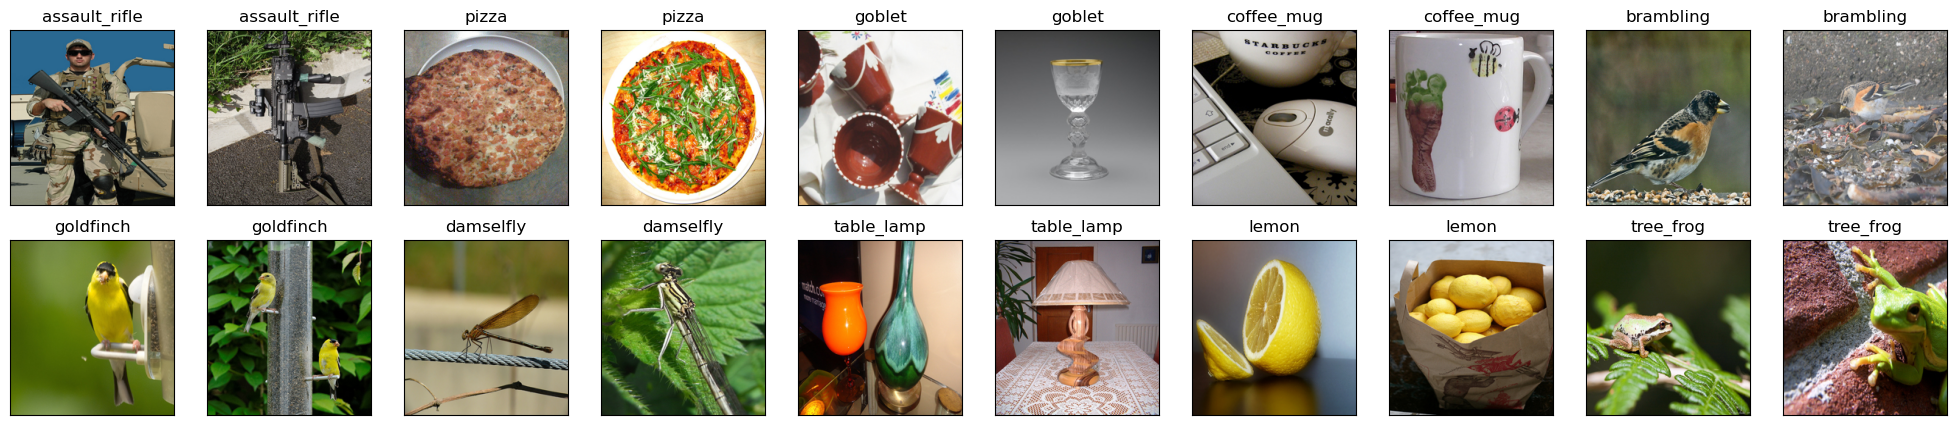

In [9]:
def display_images(imgs_dct,figsize=(25,5)):
    num_rows = max([len(list(imgs_dct.values())[i]) for i in range(len(imgs_dct))])

    num_cols = len(imgs_dct)

    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    titles = np.array([[key] * len(val) for key,val in imgs_dct.items()]).flatten()
    for ax,img,title in zip(axs.flatten(),np.array(list(imgs_dct.values())).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3),titles):
        ax.imshow(img,aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(title)
    # plt.subplots_adjust(wspace=0, hspace=0)
    
display_images(result)

We can see a random selection of 10 classes and 2 images per class above. These were taken from the subset of Image Net described in the first cell of this notebook. We will be using these 20 images to test that VGG19 is performing correctly and can give us actual predictions. From the subset that we have, we can see that there are a variety of different classes in Image Net. We have animals like the goldfinch, we have foods like lemon and pizza, and we have inanimate objects like the table lamp and goblet. We can also see that most of these images have varying levels of background or noise in them that might cause VGG19 to incorrectly classify them. For example, if we look at the assault_rifle in the top left, there are lots of things around it that could cause VGG19 to think that is a different class. We are interested in seeing how VGG19 can pull out the important features from these various images to classify such a wide variety of image classes.

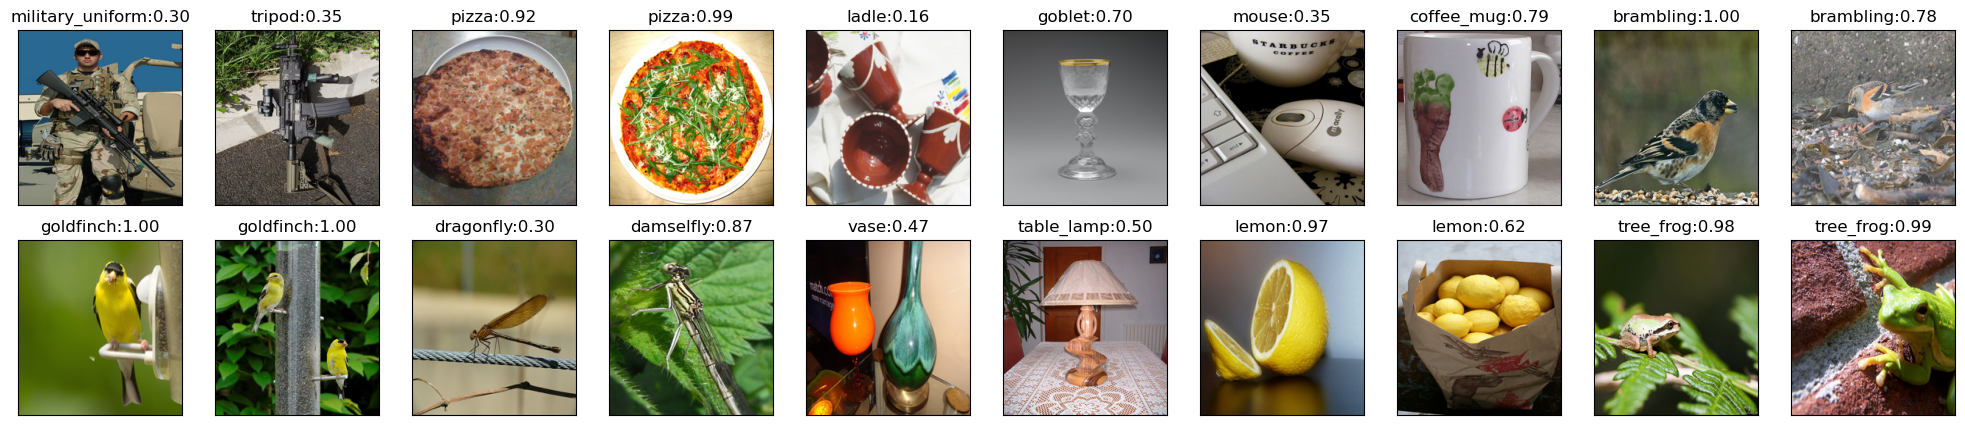

In [10]:
def display_images_with_prediction(imgs_dct,figsize=(25,5)):
    num_rows = max([len(list(imgs_dct.values())[i]) for i in range(len(imgs_dct))])

    num_cols = len(imgs_dct)
    imgs = np.array(list(imgs_dct.values())).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3)
    ready_images = np.array([preprocess_input(x) for x in imgs])
    # return ready_images
    preds = vgg(ready_images).numpy()
    preds = decode_predictions(preds)
    num_cols = int(np.ceil(float(len(imgs)/num_rows)))
    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    for ax,img,pred in zip(axs.flatten(),imgs,preds):
        ttl = pred[0][1]
        prob = round(pred[0][2],ndigits=2)
        
        ax.imshow(img,aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'{ttl}:{prob:0.2f}')
    # plt.subplots_adjust(wspace=0.2, hspace=3)

tmp = display_images_with_prediction(result)

In the above figure, we can see VGG19's predictions for the subset of images that we chose to look at. As we predicted, the images with more things in the background or around the main class are more difficult for VGG19 to predict. If we look at the top left image, I would argue that VGG correctly classified this as a military uniform because while there is an assault rifle present, there is also a man in a military uniform. We can also see that as the background gets more complex. the confidence of VGG's predictions goes down. However, VGG can detect the tree frog even though the frogs are different colors, and facing different directions and different sizes. This is very interesting to us and we want to look at some of the filters inside of VGG to shed some insight about how VGG's architecture allows it to make these accurate predictions that are invariant of size, orientation, and color. We will look into circuits, which are a collection of filters that are designed to detect certain shapes or things inside of an image. We hypothesize that there are filters that can detect different things about the tree frog that do not depend on orientation or size such as a filter that looks for eyeballs or fingers. We will test our hypothesis by choosing a filter in the next section, and attempt to provide some insight about what its role is in the VGG architecture using different CNN visualization techniques.

In [10]:
example_images_dict = get_example_images(directory_path='ImageNet-Mini/images',num_classes=np.inf,num_examples_per_class=np.inf) # Grab all images in the subset of imagenet for seeing which excite our filter the most

Classes Chosen: ['n03223299' 'n01944390' 'n02108422' 'n02859443' 'n04238763' 'n02412080'
 'n01855672' 'n02492660' 'n02971356' 'n03063689' 'n03777568' 'n03100240'
 'n03457902' 'n04311004' 'n03627232' 'n02814860' 'n04532106' 'n02808304'
 'n02093428' 'n04483307' 'n03950228' 'n02102318' 'n04523525' 'n01496331'
 'n02894605' 'n07717556' 'n04204238' 'n04254777' 'n07768694' 'n02099601'
 'n02879718' 'n03743016' 'n02110341' 'n03388183' 'n03297495' 'n02108089'
 'n03584254' 'n01728572' 'n02927161' 'n02317335' 'n02487347' 'n03788365'
 'n02910353' 'n03450230' 'n02132136' 'n03045698' 'n03146219' 'n04019541'
 'n02033041' 'n01616318' 'n04599235' 'n02730930' 'n02105162' 'n04553703'
 'n07747607' 'n07716358' 'n04428191' 'n02106030' 'n02105505' 'n04404412'
 'n02093991' 'n02797295' 'n04355933' 'n03032252' 'n02865351' 'n07584110'
 'n03956157' 'n02134418' 'n01742172' 'n02480495' 'n01980166' 'n01755581'
 'n02980441' 'n01631663' 'n01883070' 'n01675722' 'n04376876' 'n02454379'
 'n01917289' 'n02666196' 'n01744401

# Filter Visualization

## Filter Selection

In [11]:
CONV_LAYER_NAME = 'block5_conv2'
CONV_LAYER_IDX = 63
PREV_LAYER_NAME = 'block5_conv1'

![alt text](channel-63.png "block5_conv2")

This is the filter that we chose based on OpenAI's microscope. We hypothesize that this filter is looking for eyeballs, specifically in reptiles and avians because of the circles in the image look very similar to how a chamelion eye looks. It may appear like a simple circle detector at a first glance, but we argue against this mainly because it is much deeper in the network and because of the images that excite it are mostly bird or reptile eyes. (See below image taken from OpenAI Microscope). It could also be looking for small circles with a high contrast compared to the area around them (which is very similar to a pupil or a reptile or bird eye). We will dive further into this idea in the next sections where we look at what image maximally excites this image, the convolution weights within the filter, and what activations in the previous layer have the most impact on this filter.

![alt text](most_activated_microscope.png "block5_conv2")


## Excitatory Images

In [12]:
def generate_pattern(layer_name, filter_index, size=150,epochs=40,model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None)):
    #Taken from Dr. Larson's notebook on Visualizing CNN Filters
    
    # set VGG to be frozen
    for layer in model.layers:
        layer.trainable = False
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # input_img_data = np.zeros(shape=(1,size,size,3))
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = preprocess_input(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(epochs):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(filter_output, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

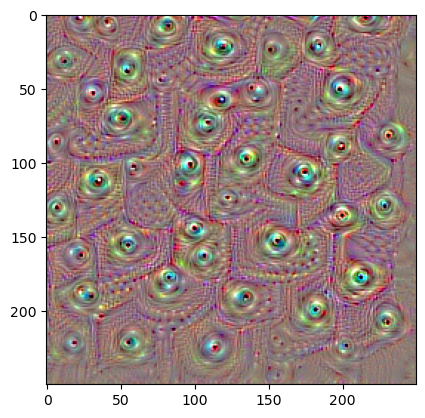

In [13]:
plt.imshow(generate_pattern(CONV_LAYER_NAME, CONV_LAYER_IDX, size=250,epochs=40))
plt.show()

This is the image that maximally excited our chosen filter. Note that the colors differ due to a difference in how we are showing the image compared to OpenAI microscope, but overall, the image is comparable to the one found online. After seeing this, we still believe that this filter is responsible for finding small eyes or small high contrast circles compared to the surrounding environment. In the next section, we will look at what images from our subset of Image Net cause this filter's activation to be the highest in order to gain more insight about what this filter is doing.

In [18]:
def find_max_excitory_images(imgs_dct,layer_name,layer_idx,filter_func=np.average,model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None)):
    for layer in model.layers:
        layer.trainable = False
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)

    # imgs = np.array(list(imgs_dct.values())).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3)
    imgs = []
    classes = []
    for name,arr in imgs_dct.items():
        for i in arr:
            imgs.append(i)
            classes.append(name)
    
    imgs = np.array(imgs).reshape(-1,IMG_SHAPE[0],IMG_SHAPE[1],3)
    ready_images = np.array([preprocess_input(x) for x in imgs])
    print(ready_images.shape)
    results = new_model.predict(ready_images)

    excite_vals = []
    for res,img in zip(results,imgs):
        excite_vals.append((filter_func(res[:,:,layer_idx]),img))
    
    class_excitations = {}
    for cls_name,(excite_val,img) in zip(classes,excite_vals):
        if class_excitations.get(cls_name,None) is None:
            class_excitations[cls_name] = []
        class_excitations[cls_name].append(excite_val)
    
    class_excitations = [(key,np.average(value)) for key,value in class_excitations.items()]

    excite_vals = sorted(excite_vals,key=lambda x: x[0],reverse=True)
    class_excitations = sorted(class_excitations,key=lambda x: x[1],reverse=True)
    return excite_vals,class_excitations

img_excitations,class_excitations = find_max_excitory_images(example_images_dict,CONV_LAYER_NAME,CONV_LAYER_IDX,filter_func=np.linalg.norm)

(3841, 224, 224, 3)
121/121 [==============================] - 3s 28ms/step


In [19]:
class_excitations[:10]

[('ear', 3302.3455),
 ('pretzel', 3063.42),
 ('great_grey_owl', 2946.408),
 ('bullfrog', 2841.9668),
 ('mud_turtle', 2487.8926),
 ('CD_player', 2467.556),
 ('loudspeaker', 2443.5981),
 ('dome', 2379.441),
 ('green_snake', 2347.3965),
 ('koala', 2222.322)]

The above classes describe the most activations that we can see from the different classes. This was calculated by taking the np.linalg.norm of the activation of our layer and averaging them across each class. It is important to note that due to some issues with some of the images in the subset of Image Net, we had to remove some images (some were black and white, and some had 4 color channels) which caused some of the classes to become imbalanced. Overall, we see that the class that most excited our filter was the 'ear' class (which is an ear of corn, not an ear as in human ear) followed by pretzel and then various animals. This made us think about our hypothesis of the filter detecting animal eyes and made us lean more towards it being responsible for finding small circular-shaped objects that have a high contrast compared to the area around them. The ear of corn image that was in our dataset had indents and therefore small circles inside each kernel of the corn. Considering this and the pretzel class exciting the filter the most on average, we made the determination that while the filter is used for finding small eyes in birds and reptiles, it is also used to find any small circular shape that has a sharp contrast against the area around it. We will further explore this idea in the cells below where we look at each image that excited the filter the most (without averaging across classes).

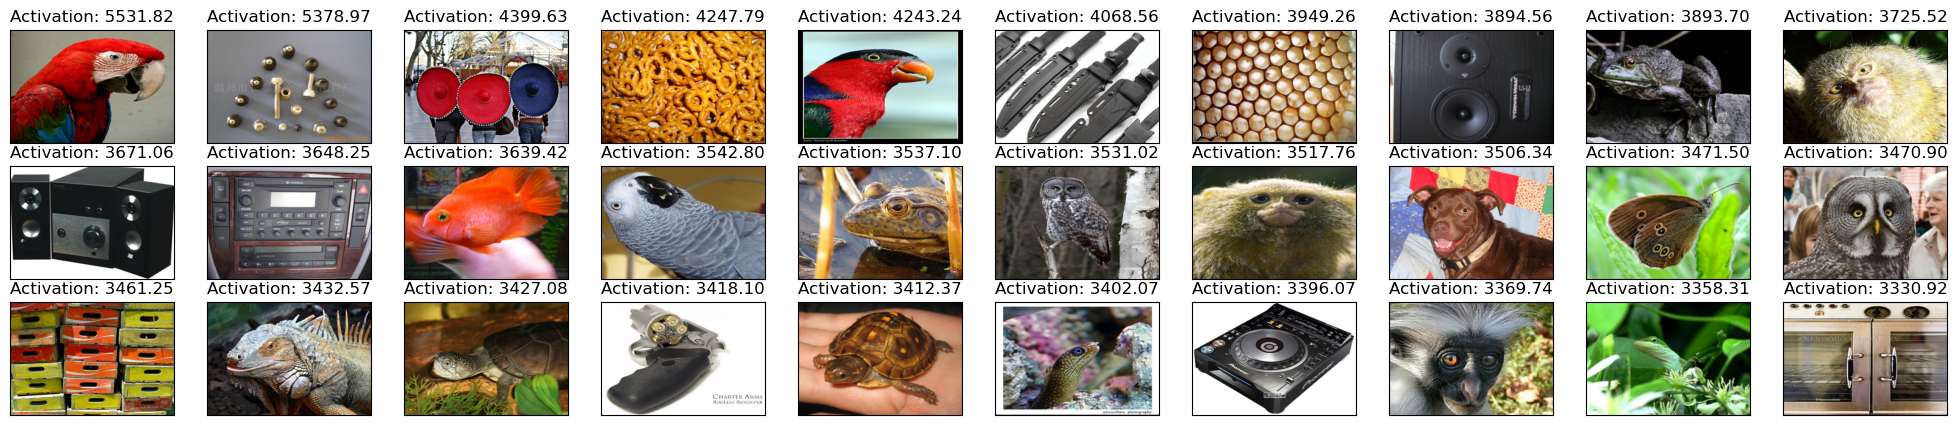

In [20]:
def plot_max_excitory_images(imgs_array,num_to_plot=10,num_rows=2,figsize=(25,5)):
    num_cols = int(np.ceil(num_to_plot / num_rows))
    fig, axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    subset = imgs_array[:num_to_plot]
    for ax,val in zip(axs.flatten(),subset):
        ax.imshow(val[1],aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'Activation: {val[0]:0.2f}')
    
    return subset
top_imgs = plot_max_excitory_images(img_excitations,num_to_plot=30,num_rows=3)

The figure above shows which individual images excited our filter's activation the most (based on the same metric as above). As we can see, there are a variety of different classes present here, it is not restricted to just avian and reptile-based images. The commonality between all of these images, that we deduced, was that each of them has at least one, and most of them have multiple, small circles that contain a high contrast compared to the area around it. This is why classes such as speaker is being picked up because there is a distinct small circle in the center. Similarly, we look at the honey-comb image in the top right which also has small circular shaped lines that have a very sharp contrast compared to the area around them. The most surprising image that was present here to us was the image of the knives in the top center but upon closer inspection, we believe that the small circular and oval-shaped holes in the knife cases are what is causing our filter to get excited because of the white background having such a strong contrast compared to the black knife that allows a small circle of white to pass through the black. 

## Filter Analysis by Channel

In [21]:
def get_top_strongest_weights(layer_name,layer_idx,top_n=10,model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None),evaluate_function=np.linalg.norm):
    layer = model.get_layer(layer_name)
    filter_weights = layer.get_weights()[0]
    filter_weights = filter_weights[:,:,:,layer_idx]
    result = []
    for idx in range(filter_weights.shape[-1]):
        result.append((idx,evaluate_function(filter_weights[:,:,idx])))
    
    return sorted(result,key=lambda x: x[1],reverse=True)[:top_n]
    # return filter_weights

top_filters = get_top_strongest_weights(CONV_LAYER_NAME,CONV_LAYER_IDX,top_n=10)

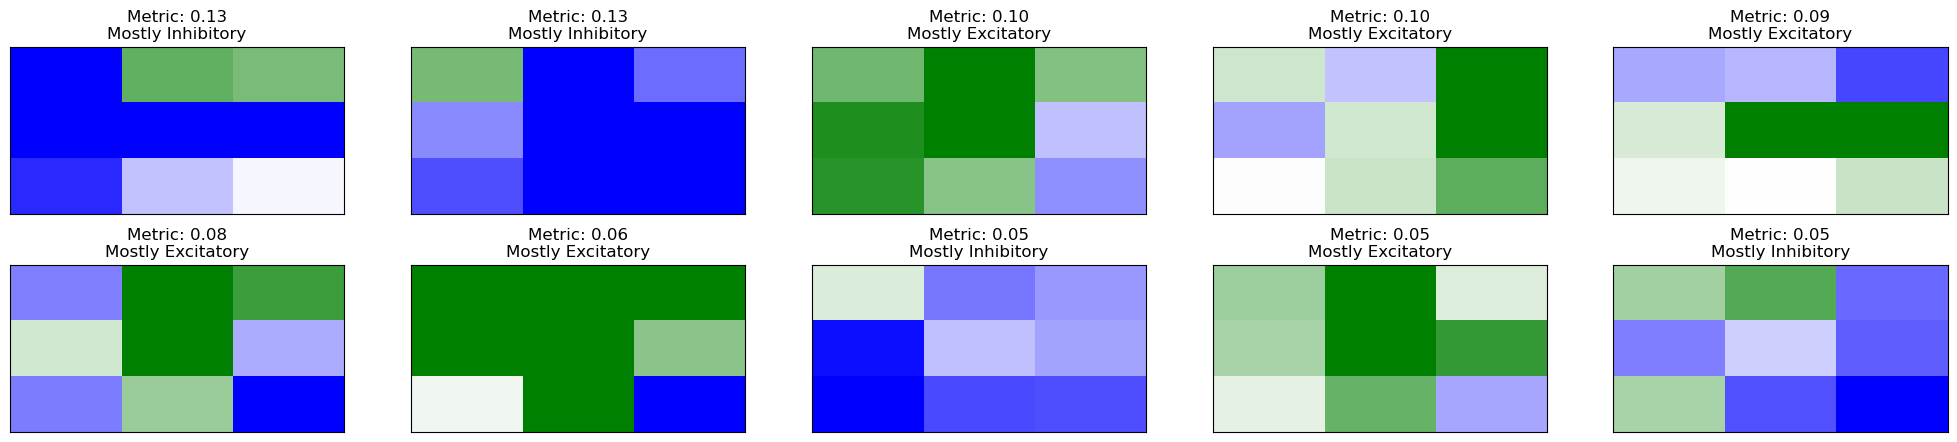

In [22]:
import matplotlib.colors as colors
def display_top_filters(layer_name,layer_idx,top_filters,model=tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None),num_rows=2,figsize=(25,5)):
    num_cols = int(np.ceil(len(top_filters) / num_rows))
    layer = model.get_layer(layer_name)
    filter_weights = layer.get_weights()[0]
    filter_weights = filter_weights[:,:,:,layer_idx]
    fig,axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    norm=plt.Normalize(-0.007,0.007)
    cmap = colors.LinearSegmentedColormap.from_list("", ["blue",'white',"green"])
    for i,ax in enumerate(axs.flatten()):
        # filt = prepare_image_for_display(filter_weights[:,:,i])
        filt = filter_weights[:,:,i]
        # print(filt)
        ax.imshow(filt,aspect='auto',cmap=cmap,norm=norm)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'Metric: {top_filters[i][1]:0.2f}\nMostly {"Inhibitory" if np.average(filt) < 0 else "Excitatory"}')
    
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
display_top_filters(CONV_LAYER_NAME,CONV_LAYER_IDX,top_filters)

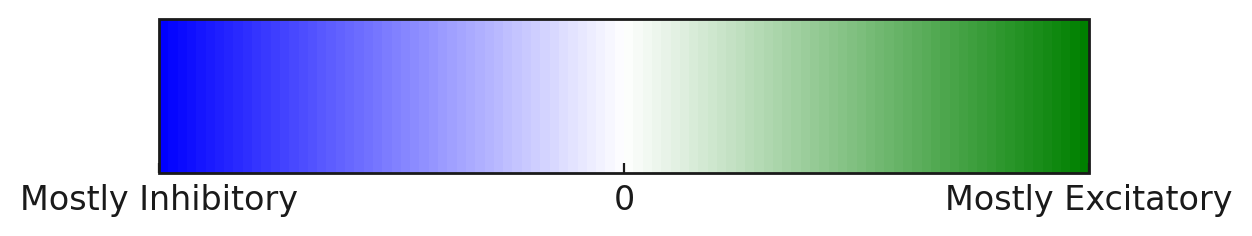

The visual above shows the filters that showed the most positive or negative responses to previous layer inputs. The strength of the filter was again determined by `np.linalg.norm`. The visualizations are of each of the filter coefficients for the top 10 strongest filters where blue cells have negative coefficients, white are close to 0, and green have positive coefficients. We determined if the filters were mostly inhibitory or mostly excitatory by taking the average of the filter coefficients for each filter. If that average was above 0 then we classified it as excitatory and if that average was below 0, then we classified it as mostly inhibatory. Very specifically the hard green color is if the value is above **0.07** and the hard blue value is below **-0.07**. 

Additionally, but not visualized in this notebook, we viewed all filters, for the filters outside of this top 10 the metrics scores would all fall off very hard after 0.05 found in the 10th place filter. The values quickly go to zero at around a 0.0001 which makes most all filters outside of the top 10 not influential which is why we do not view these filters.

We will look at the images that excite each of the inputs to these filters in the next section to dive further into the circuit that we believe exists to find small circular objects with a high contrast compared to the area around them.



In [ ]:
top_filters

[(6, 0.12797067),
 (168, 0.1262323),
 (129, 0.10249913),
 (251, 0.10240816),
 (196, 0.09096281),
 (297, 0.075551964),
 (174, 0.055974964),
 (420, 0.05409162),
 (360, 0.052835487),
 (34, 0.051753003)]

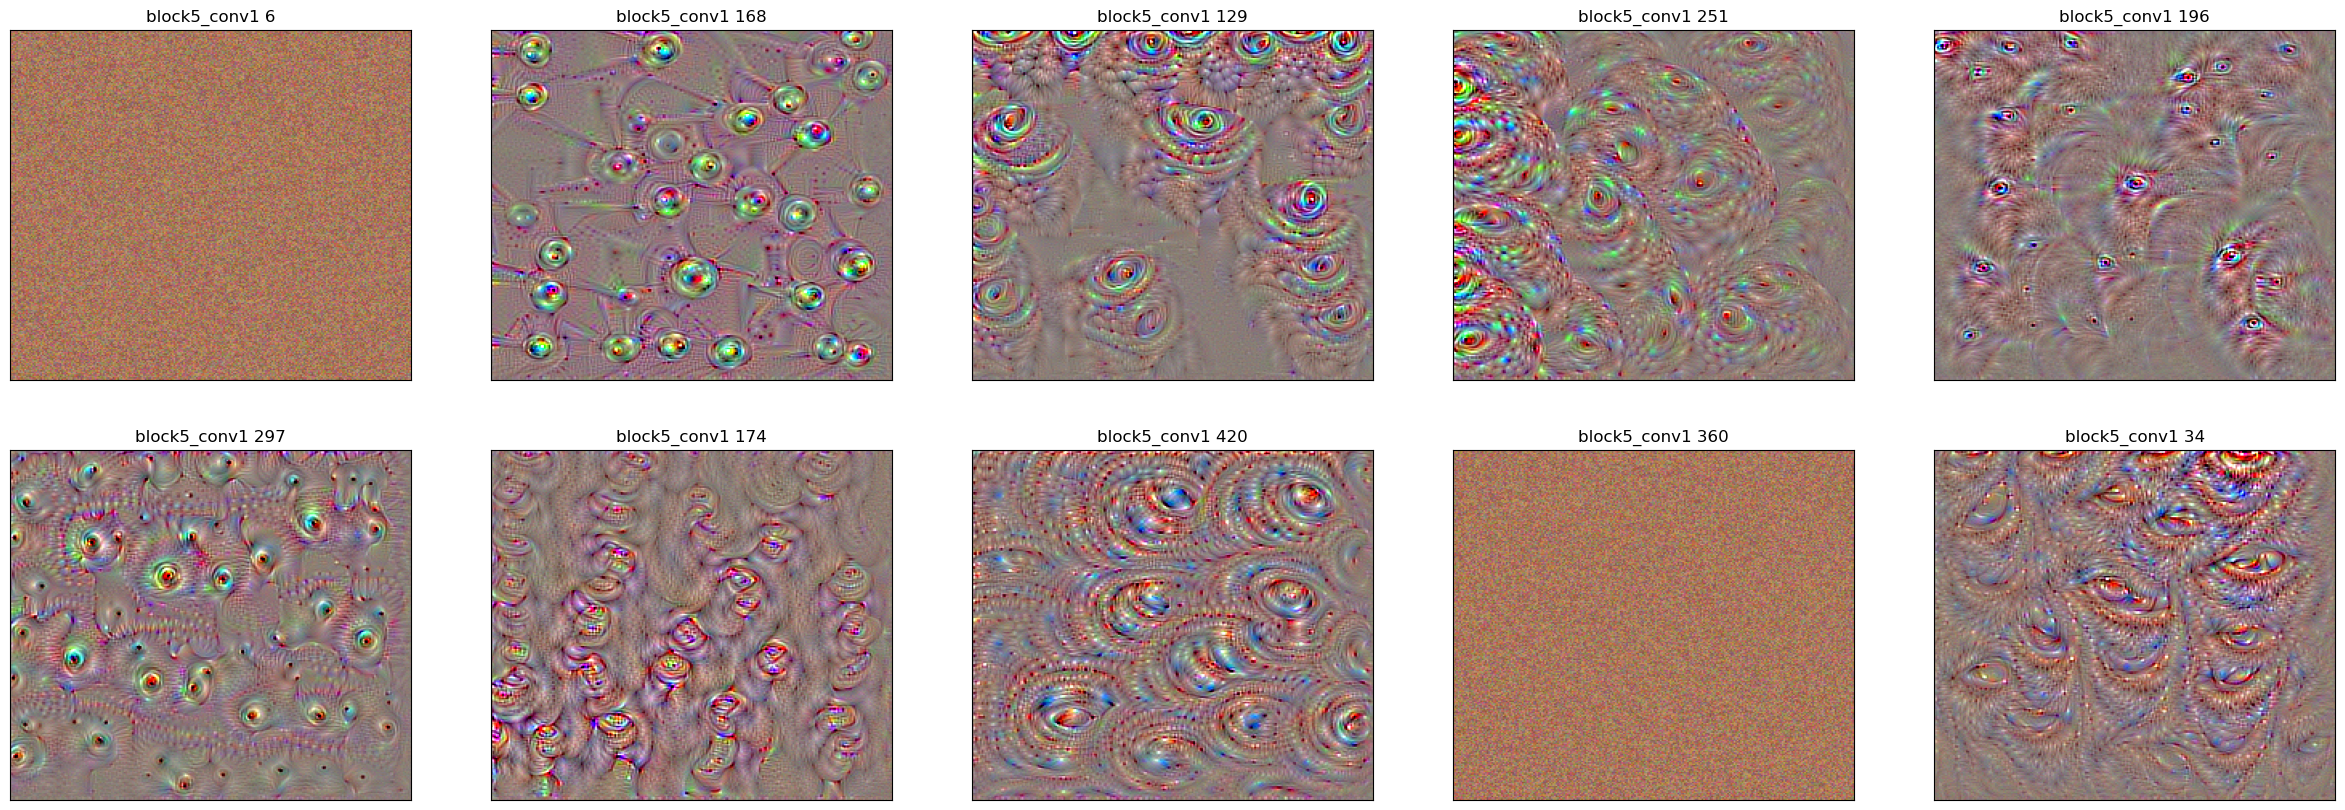

In [24]:
def plot_top_filters_excited_input(layer_name,top_filters,model=tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_tensor=None),num_rows=2,figsize=(30,10),size=150,epochs=40):
    num_cols = int(np.ceil(len(top_filters) / num_rows))
    fig,axs = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=figsize)
    for ax,filter_tuple in zip(axs.flatten(),top_filters):
        ax.imshow(generate_pattern(layer_name,filter_tuple[0],size=size,epochs=epochs,model=model),aspect='auto')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'{layer_name} {filter_tuple[0]}')

plot_top_filters_excited_input(PREV_LAYER_NAME,top_filters,epochs=60,size=250)

The above visualization shows what image excites the layers in the previous output the most. We only took the same top 10 that had the strongest filter coefficients shown in the same order as the graphic above (meaning that the image in the top right corresponds to the filter coefficients in the top right in the previous visualization). Note that the images for `block5_conv1 6` and `block5_conv1 360` appear to have gotten stuck in a local maximum when trying to find the maximum exciting image for those filters. We attempted to rerun this graphic with varying initializations for the random noise, as well as different numbers of epochs but at least 1 of the filters displayed would always end up showing pure noise so we settled for this visualization as it allows us to talk on most of the filters. As we can see from this graphic and the previous one, the filters that are mostly inhibitory are dealing with large curves/large circles or potentially even eyes that are more human-shaped, which would indicate that the filter is only looking for small circles that are distinct from the area around them. We also note that the filters that are mostly excitatory appear to be filters looking for different eye shapes, all of which are small. For example, if we look at the `block_5_conv1 196` image, those appear to be avian eyes and possibly even bleeding into avian beaks, `block5_conv1 297` appears to be very small reptile eyes, `block5_conv1 251` appears to be looking for larger reptile eyes (large for a reptile, still relatively small compared to other eyes or circular objects). Looking at `block5_conv1 168`, this image makes sense to be inhibitory because it depicts larger circles and appears to not have a distinct center of the circles but a smoother transition between the circle itself and the surrounding areas which would make our filter less sensitive to just any random circle and therefore support our hypothesis that the filter is looking for circles with a high contrast to the surrounding pixels.

Seeing these visualizations of the filters makes us confidently believe that a circuit exists here, due to the fact that as mentioned above each filter appears to be looking for eye/circular shapes, and each metric of these eye-related filters has a positive metric score.

# Conclusions

Initially, we believed that our selected filter was a pose-invariant small reptile/avian eye detector. Upon further analysis, we questioned our hypothesis because we saw different images that excited our neuron than we expected. We saw images that were not avian or reptilian in nature, but just common objects like speakers or ears of corn. This caused us to reconsider what this neuron was doing, but we ended up cementing our original hypothesis of the circuit representing a filter that pose-invariant small reptile/avian eye detector.

We remained on our original hypothesis due to the fact that we used a sample size of only two images from each class when testing what images maximally excited that layer of the network. This caused there to be much more variety in the type of image that was shown to be maximally excited, causing us some confusion. Nonetheless, we concluded that if the images in OpenAI Microscope were sampled in a similar way, it would most like show a similar output in the types of images that maximally excite the filter.

It is important to note that although this filter is a pose-invariant small reptile/avian eye detector, it is also very influential in the classifcation of other types of images as well. Specifically we determined that it is also partially responsible for detecting small circular objects that have a sharp contrast relative to the area around them. From our analysis of images that excite this neuron, we deduced that it is pose invariant because the orientation of the high contrast circle/oval was irrelevant, but not size invariant. It was not a generic circle detector, it appeared to only be sensitive to small circles, not larger ones. We determined that while the neuron was excited by many different classes, it was not a polysemantic neuron because those classes all had the commonality that they contained small circles that had a sharp contrast compared to the area around them.